In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
import torchvision
from torch.utils.data import Dataset, DataLoader
import numpy as np
import math
import glob
import torchvision.transforms as transforms
#import cv2 as cv

os.chdir('/Users/ethanpickering/Downloads/Cam1')

In [2]:
class ChickenDataset(Dataset):

    def __init__(self, x, y):
        self.n_samples = y.shape[0]

        # here the first column is the class label, the rest are the features
        self.x_data = x # size [n_samples, n_features (pixels x pixels)]
        self.y_data = y # size [n_samples, 1]        
        
    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples

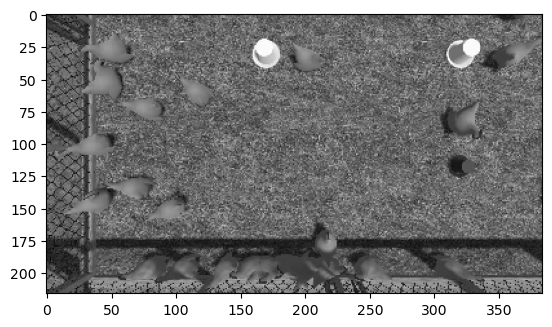

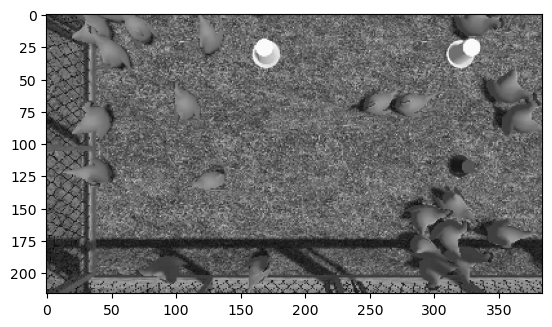

In [15]:
# Load in all Images
# Define a transform to convert
# the image to torch tensor
transform = transforms.Compose([
    transforms.ToTensor()
])

ds_x = 5
ds_y = 5

path = glob.glob("*.jpg")

#t_img = torch.empty((10, 1, 1080, 1920))
t_img = torch.empty((999, 1, 216, 384))
#t_img = torch.empty((10, 1, 27, 32))
#t_img = torch.empty((10, 1, 60, 60))
y_img = torch.empty((999, 1))
j = 0
for img in path:
    n = cv2.imread(img)
    n = cv2.cvtColor(n, cv2.COLOR_BGR2RGB)
    r1 = n[:,:,0] # get 1 channel
    r1 = cv2.resize(r1, None, fx=1/ds_x, fy=1/ds_y)
    t1 = transform(r1)
    t_img[j,:,:,:] = t1
    y_img[j,:] = 1
    j = j+1
    #n x 1 x px x py

t_img_test = t_img[949:998,:,:,:]
y_img_test = y_img[949:998,:]
    
end_val = 100
t_img = t_img[0:end_val,:,:,:]
y_img = y_img[0:end_val,:]

plt.imshow(t_img[0,0,:,:])
plt.show()
plt.imshow(t_img_test[0,0,:,:])
plt.show()

dataset = ChickenDataset(t_img, y_img)
# Ok, now we have the dataset set up. Lets see if we can recreate the training
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=20,
                                          shuffle=True)

dataset_test = ChickenDataset(t_img_test, y_img_test)
data_loader_test = torch.utils.data.DataLoader(dataset=dataset_test,
                                          batch_size=10,
                                          shuffle=True)

In [16]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()        
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> N, 16, 30, 30 (60, 60)
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 15, 15 (14, 16)
            nn.ReLU(),
            nn.Conv2d(32, 64, 4) # -> N, 64, 1, 1
        )
        
        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5)

In [ ]:
import time
# Point to training loop video
num_epochs = 100
outputs = []
outputs_t = []

for epoch in range(num_epochs):
    start = time.perf_counter()
    for (img, _) in data_loader:
        #img = img.reshape(-1, 28*28) # -> use for Autoencoder_Linear
        recon = model(img)
        loss = criterion(recon, img)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    for (img_t, _) in data_loader_test:
        recon_t = model(img_t)
        loss_t = criterion(recon_t, img_t)
        
    end = time.perf_counter()
    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}, Time:{end-start:.4f}')
    print(f'Testing, Loss:{loss_t.item():.4f}')

    outputs.append((epoch, img, recon))
    outputs_t.append((epoch, img_t, recon_t))

Epoch:1, Loss:0.0107, Time:2.5700
Testing, Loss:0.0106
Epoch:2, Loss:0.0103, Time:2.2210
Testing, Loss:0.0102
Epoch:3, Loss:0.0100, Time:2.2604
Testing, Loss:0.0099
Epoch:4, Loss:0.0097, Time:2.2557
Testing, Loss:0.0096


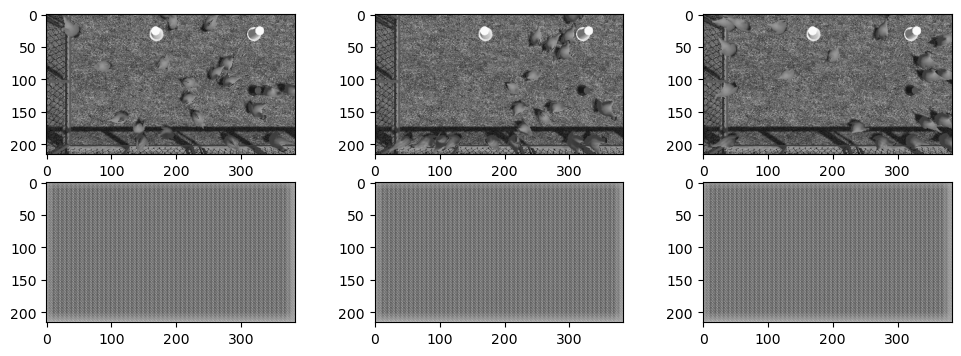

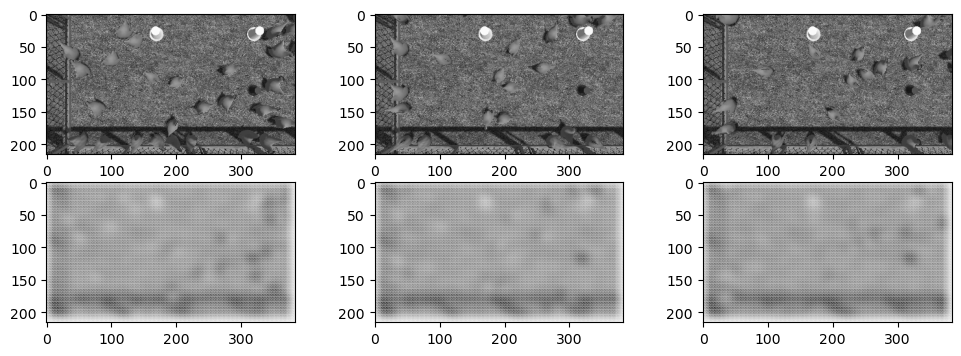

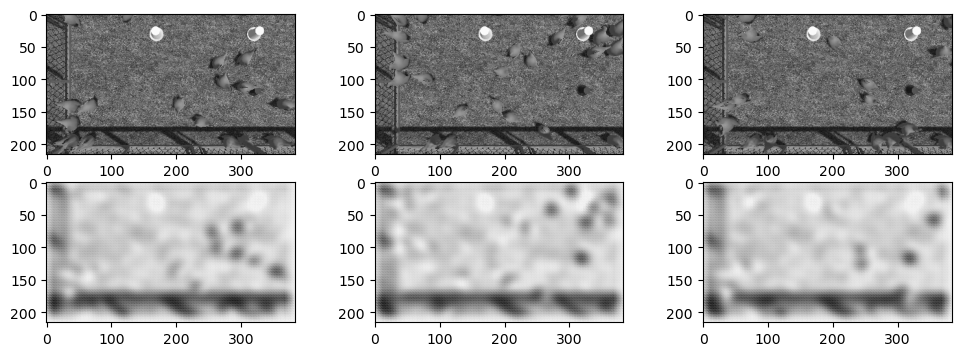

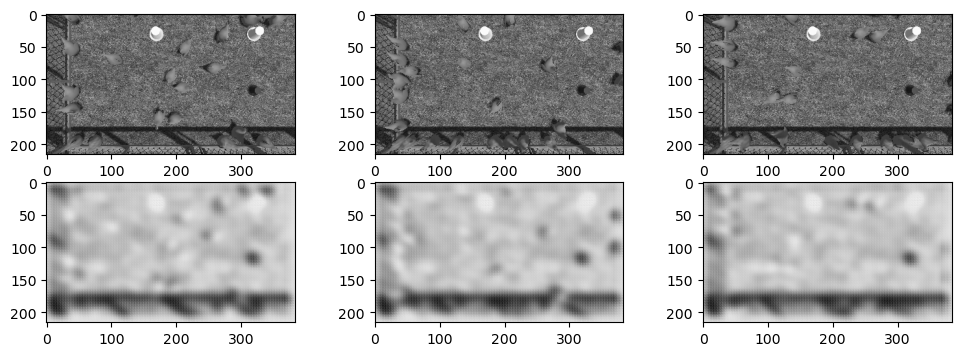

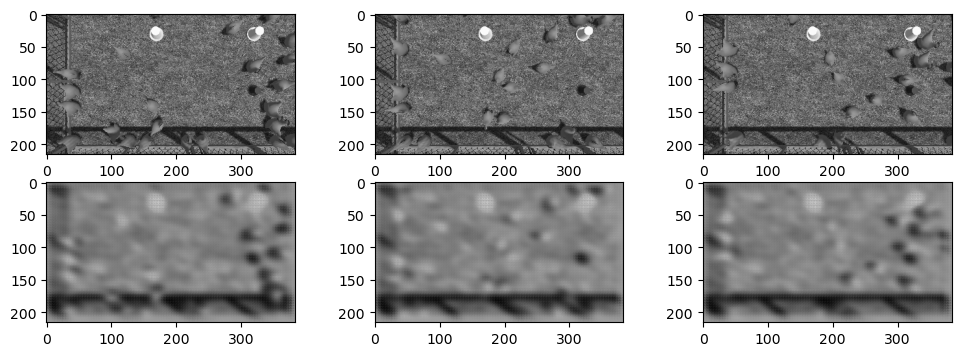

In [18]:
for k in range(0, num_epochs, 25):
    plt.figure(figsize=(12, 4))
    plt.gray()
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 3: break
        plt.subplot(2, 3, i+1)
        #item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])
            
    for i, item in enumerate(recon):
        if i >= 3: break
        plt.subplot(2, 3, 3+i+1) # row_length + i + 1
        #item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])

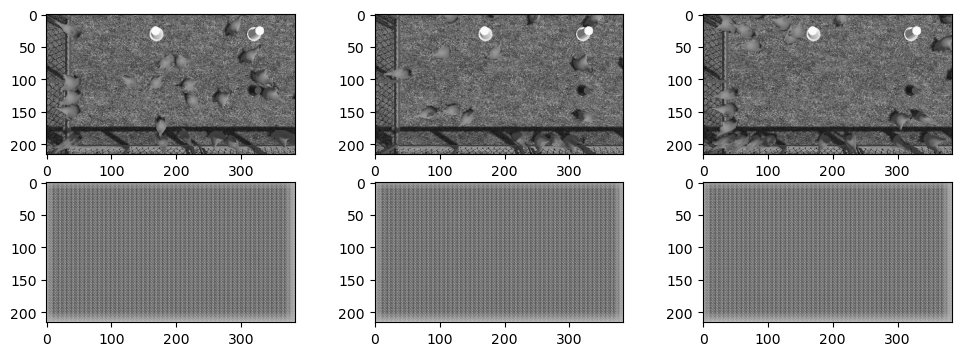

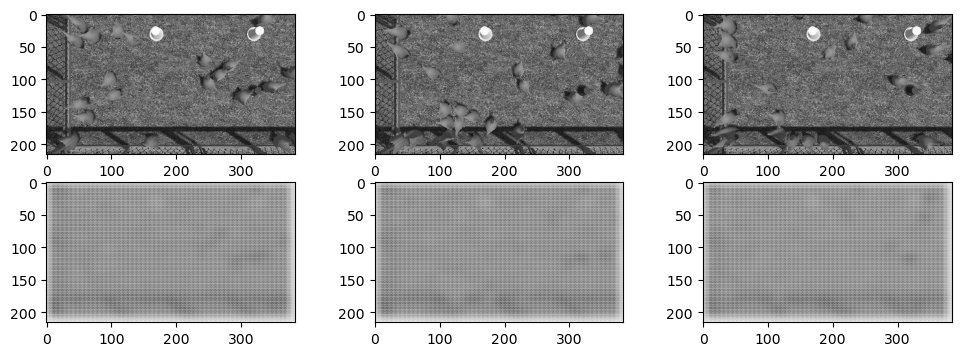

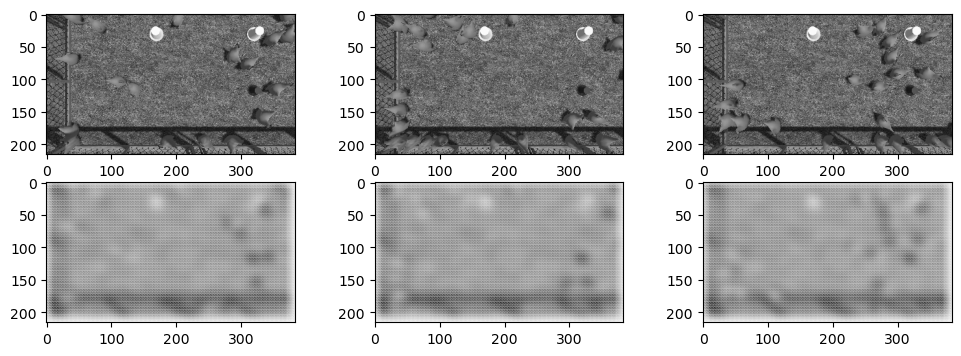

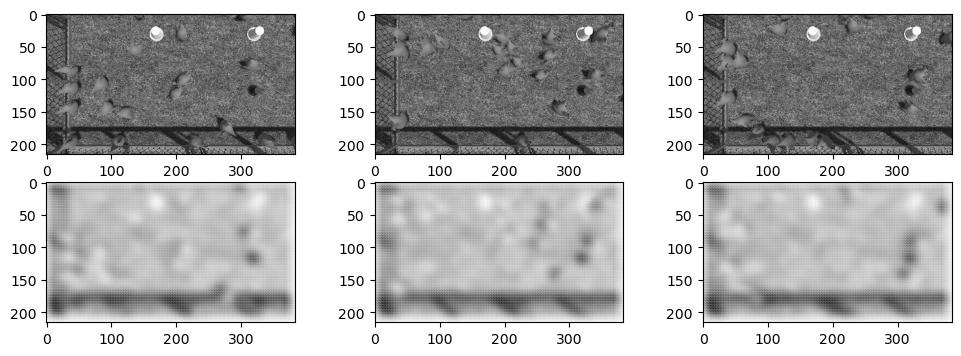

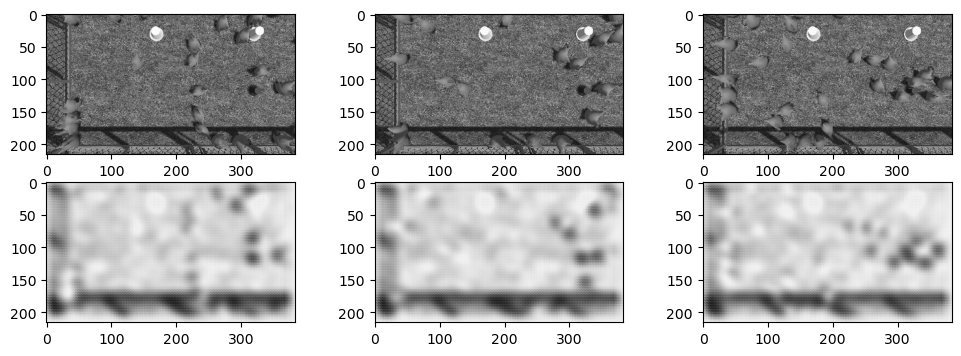

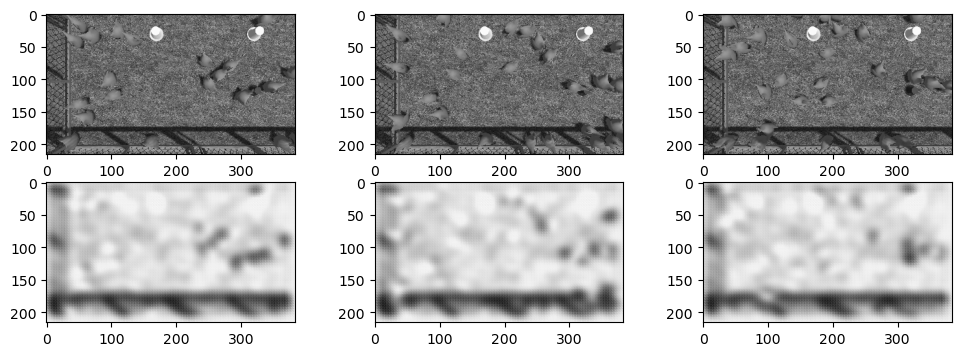

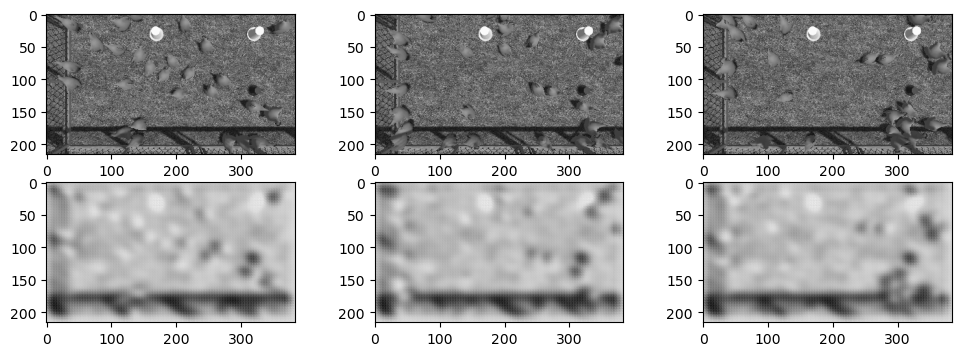

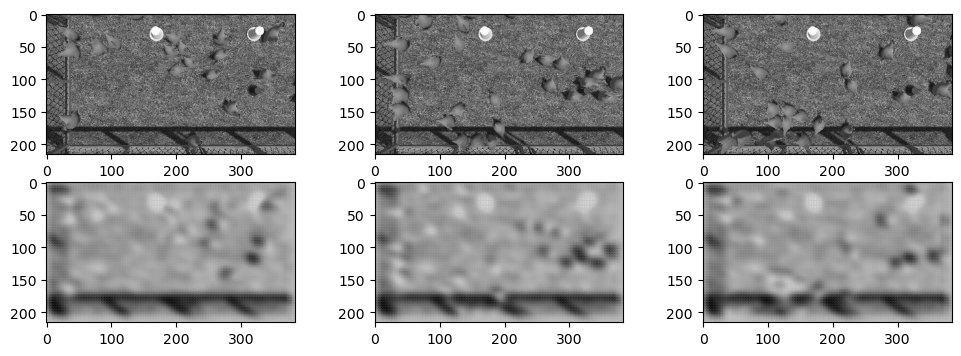

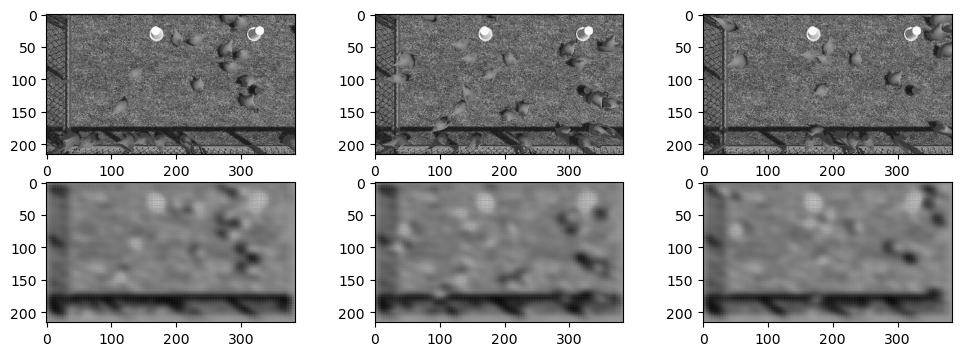

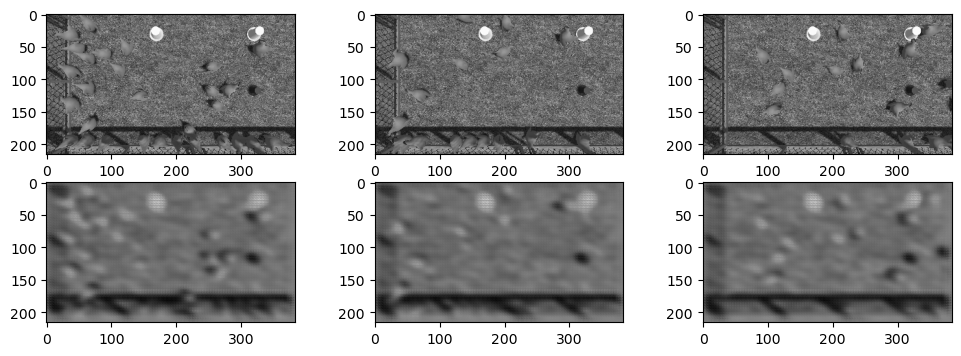

In [19]:
for k in range(0, num_epochs, 25):
    plt.figure(figsize=(12, 4))
    plt.gray()
    imgs = outputs_t[k][1].detach().numpy()
    recon = outputs_t[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 3: break
        plt.subplot(2, 3, i+1)
        #item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])
            
    for i, item in enumerate(recon):
        if i >= 3: break
        plt.subplot(2, 3, 3+i+1) # row_length + i + 1
        #item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])